📌 1. Setup & Load Data

In [ ]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

# Get the absolute paths
BASE_DIR = os.getcwd()  # This ensures correct relative path usage
DATA_PATH = os.path.join(BASE_DIR, "Q5_datasets")
RESULTS_PATH = os.path.join(BASE_DIR, "Q5_results")

# Ensure results directory exists
os.makedirs(RESULTS_PATH, exist_ok=True)

# Define dataset file paths
interaction_file = os.path.join(DATA_PATH, "y2h_union.txt")
essential_genes_file = os.path.join(DATA_PATH, "essential_genes.csv")

# Verify that the files exist
if not os.path.exists(interaction_file):
    raise FileNotFoundError(f"Interaction file not found: {interaction_file}")

if not os.path.exists(essential_genes_file):
    raise FileNotFoundError(f"Essential genes file not found: {essential_genes_file}")

# Load the interaction dataset
df = pd.read_csv(interaction_file, sep="\t", header=None)

# Create an undirected graph
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row[0], row[1])

# Print basic network stats
print(f"Number of nodes (proteins): {G.number_of_nodes()}")
print(f"Number of edges (interactions): {G.number_of_edges()}")



Number of nodes (proteins): 2018
Number of edges (interactions): 2930


📌 2. Construct YPI & Plot Degree Distribution

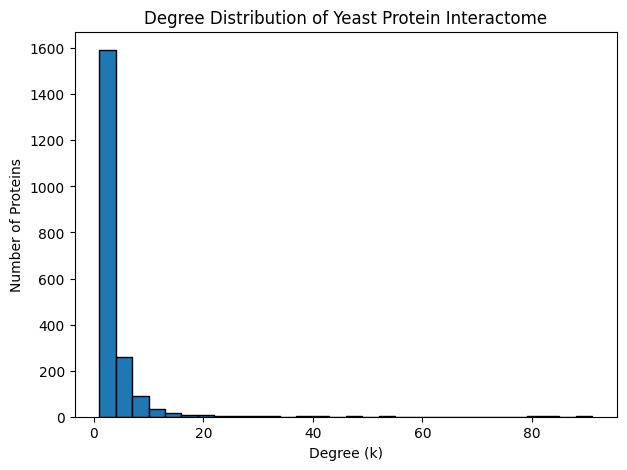

In [ ]:
degrees = [deg for _, deg in G.degree()]

# Plot degree distribution
plt.figure(figsize=(7,5))
plt.hist(degrees, bins=30, edgecolor='black')
plt.title("Degree Distribution of Yeast Protein Interactome")
plt.xlabel("Degree (k)")
plt.ylabel("Number of Proteins")

# Save plot
plt.savefig(os.path.join(RESULTS_PATH, "degree_distribution.png"))
plt.show()



📌 3.  
𝐶
(
𝑘
)
×
𝑘


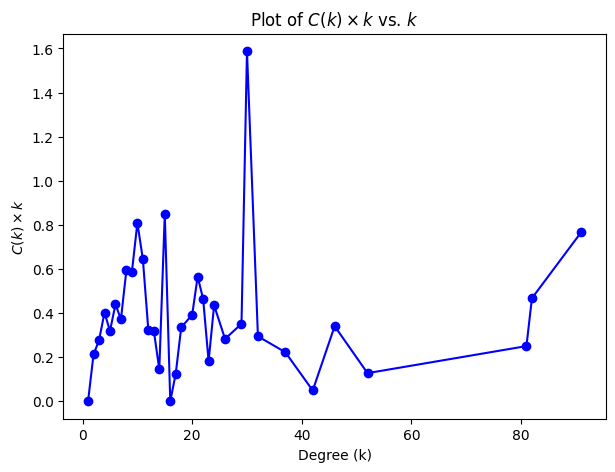

In [ ]:

from collections import defaultdict

# Compute clustering coefficient for each node
clustering_dict = nx.clustering(G)

# Group clustering values by node degree
deg_to_clust = defaultdict(list)
for n in G.nodes():
    k = G.degree(n)
    deg_to_clust[k].append(clustering_dict[n])

degree_vals = sorted(deg_to_clust.keys())
ck_times_k = [np.mean(deg_to_clust[k]) * k for k in degree_vals]

# Plot C(k)*k vs. k
plt.figure(figsize=(7,5))
plt.plot(degree_vals, ck_times_k, 'bo-')
plt.title(r"Plot of $C(k)\times k$ vs. $k$")
plt.xlabel("Degree (k)")
plt.ylabel(r"$C(k)\times k$")

# Save plot
plt.savefig(os.path.join(RESULTS_PATH, "ck_times_k_plot.png"))
plt.show()


(b) Identify Key Proteins & Fraction of Essential Proteins vs. Degree

In [ ]:

#IDENTIFY TOP HUB PROTEINS
# Sort proteins by degree (highest first)
degree_list = sorted(G.degree(), key=lambda x: x[1], reverse=True)

# Print top 10 hub proteins
print("🔹 Top 10 highest-degree proteins:")
for protein, deg in degree_list[:10]:
    print(f"{protein}: degree = {deg}")


🔹 Top 10 highest-degree proteins:
YLR291C: degree = 91
YLR423C: degree = 82
YNL189W: degree = 81
YIR038C: degree = 52
YDR510W: degree = 46
YBR261C: degree = 42
YDR479C: degree = 37
YDR100W: degree = 32
YPL070W: degree = 30
YDL100C: degree = 29


In [ ]:

# LOAD & PROCESS ESSENTIAL GENES

essentials_df = pd.read_csv(essential_genes_file)

# Create a dictionary {Gene : Essential (1/0)}
essential_dict = dict(zip(essentials_df["Gene"], essentials_df["Essential"]))

# Match proteins in network with essentiality info
node_data = []
for n in G.nodes():
    k = G.degree(n)
    is_essential = essential_dict.get(n, 0)  # Default to 0 if gene not found
    node_data.append((n, k, is_essential))

# Convert to DataFrame
node_df = pd.DataFrame(node_data, columns=["Protein", "Degree", "Essential"])

# Group by degree and compute fraction of essential proteins
grouped = node_df.groupby("Degree")
frac_essential_by_deg = grouped["Essential"].mean()


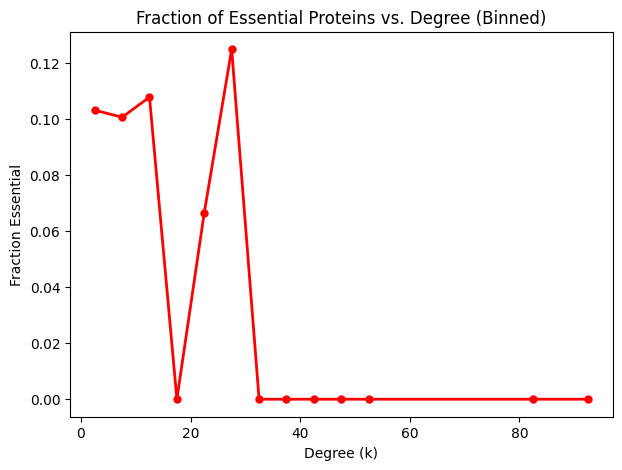

In [ ]:

# PLOT FRACTION OF ESSENTIAL PROTEINS

# Binning for smoother visualization
bin_size = 5
bin_edges = np.arange(0, max(frac_essential_by_deg.index) + bin_size, bin_size)
binned_degrees = []
binned_essentials = []

for i in range(len(bin_edges) - 1):
    lower, upper = bin_edges[i], bin_edges[i+1]
    values_in_bin = frac_essential_by_deg[(frac_essential_by_deg.index >= lower) & (frac_essential_by_deg.index < upper)]
    
    if not values_in_bin.empty:
        binned_degrees.append((lower + upper) / 2)  # Bin midpoint
        binned_essentials.append(values_in_bin.mean())

# Plot
plt.figure(figsize=(7,5))
plt.plot(binned_degrees, binned_essentials, 'ro-', linewidth=2, markersize=5)
plt.title("Fraction of Essential Proteins vs. Degree (Binned)")
plt.xlabel("Degree (k)")
plt.ylabel("Fraction Essential")

# Save plot
plt.savefig(os.path.join(RESULTS_PATH, "fraction_essential_vs_degree.png"))
plt.show()


(c) Implement Random vs. Targeted Node D

In [ ]:

# RANDOM VS. TARGETED ATTACK FUNCTION

def largest_component_size(G_):
    """Return size of largest connected component"""
    if G_.number_of_nodes() == 0:
        return 0
    return max(len(c) for c in nx.connected_components(G_))

def avg_component_size(G_):
    """Return average component size"""
    comps = list(nx.connected_components(G_))
    if len(comps) == 0:
        return 0
    return sum(len(c) for c in comps) / len(comps)

def attack_simulation(G, attack_type="random"):
    """Perform random or targeted attack and measure largest & average component sizes"""
    nodes = list(G.nodes())
    
    if attack_type == "targeted":
        nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)  # High-degree first
        nodes = [n for n, _ in nodes]

    fraction_removed = []
    LCC_sizes = []
    avgC_sizes = []
    G_copy = G.copy()
    total = len(nodes)

    for i, node in enumerate(nodes):
        G_copy.remove_node(node)
        fraction_removed.append((i+1) / total)
        LCC_sizes.append(largest_component_size(G_copy))
        avgC_sizes.append(avg_component_size(G_copy))

    return fraction_removed, LCC_sizes, avgC_sizes

# Run both simulations
frac_rand, LCC_rand, avgC_rand = attack_simulation(G, attack_type="random")
frac_targ, LCC_targ, avgC_targ = attack_simulation(G, attack_type="targeted")


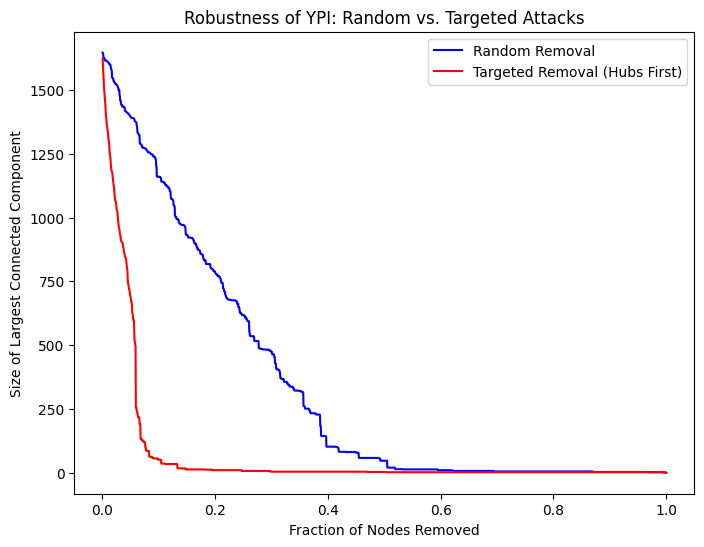

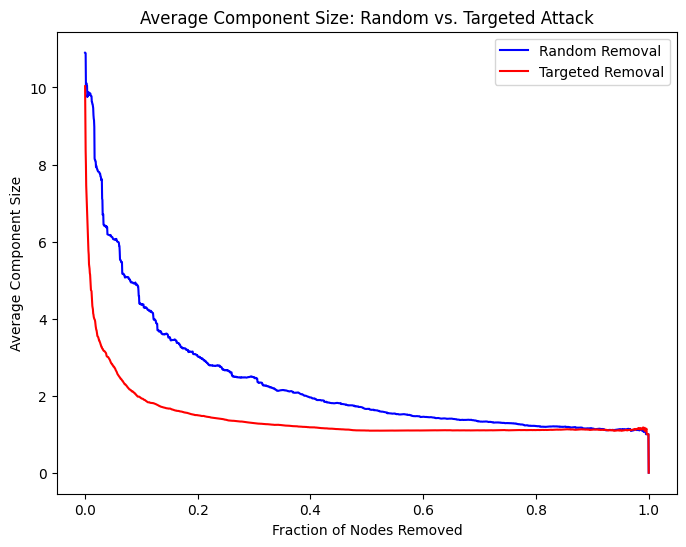

In [ ]:

# PLOT NETWORK ROBUSTNESS

plt.figure(figsize=(8,6))
plt.plot(frac_rand, LCC_rand, label="Random Removal", color="blue")
plt.plot(frac_targ, LCC_targ, label="Targeted Removal (Hubs First)", color="red")
plt.xlabel("Fraction of Nodes Removed")
plt.ylabel("Size of Largest Connected Component")
plt.title("Robustness of YPI: Random vs. Targeted Attacks")
plt.legend()

# Save plot
plt.savefig(os.path.join(RESULTS_PATH, "robustness_random_vs_targeted.png"))
plt.show()


# (Optional) PLOT AVERAGE COMPONENT SIZE

plt.figure(figsize=(8,6))
plt.plot(frac_rand, avgC_rand, label="Random Removal", color="blue")
plt.plot(frac_targ, avgC_targ, label="Targeted Removal", color="red")
plt.xlabel("Fraction of Nodes Removed")
plt.ylabel("Average Component Size")
plt.title("Average Component Size: Random vs. Targeted Attack")
plt.legend()

# Save plot
plt.savefig(os.path.join(RESULTS_PATH, "average_component_size_random_vs_targeted.png"))
plt.show()

